In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.utils.data as Data
data = pd.read_csv('test3.csv', encoding='gbk')

In [93]:
dataX = []  # 属性
dataY = []  # 标签
tempX = []  # 储存某个历史第0天数据
tempY = []  # 储存某个未来第1到168天数据

for index, rows in data.iterrows():
    temp_data = [rows['pay_num'], rows['payment_orders'], rows['refund_orders'], rows['cancel_orders'],
                 rows['income'], rows['refund_income'], rows['actual_orders'], rows['续费率'], rows['实际收入'],
                 rows['保留率'], rows['ltv']]

    if len(tempX) == 0:
        tempX.append(temp_data)
    else:
        tempY.append(temp_data)

    if len(tempY) == 168:
        dataX.append(tempX)
        dataY.append(tempY)
        tempX = []
        tempY = []

In [94]:
dataX=torch.tensor(dataX)#列表转Tensor
dataY=torch.tensor(dataY)#列表转Tensor
 
dataset=Data.TensorDataset(dataX,dataY)
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])#以8:2比例划分训练集和测试集
 
train_loader = Data.DataLoader(
            dataset=train_dataset,
            batch_size=100,
            shuffle=True
        )
test_loader = Data.DataLoader(
            dataset=test_dataset,
            batch_size=100,
            shuffle=False
        )

In [95]:
from torch.nn import LSTM,Module,Linear
class MyModel(Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.lstm=LSTM(input_size=11,hidden_size=11,num_layers=3,batch_first=True)
        self.linear=Linear(1*11,168*11)#将结果映射到第1到168天数据
    def forward(self,x):
        return self.linear(self.lstm(x)[0].reshape(-1,1*11))

In [96]:
# loaded_model = torch.load('0predict1to168.pkl')
model=MyModel()
# model.load_state_dict(loaded_model)

In [97]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lossList=[]#记录训练loss
lossListTest=[]#记录测试loss
epochs = 10000
for epoch in range(epochs):
    loss_nowEpoch=[]
    model.train()
    for step, (batch_x, batch_y) in enumerate(train_loader):
        out=model(batch_x)#模型输入
        Loss = F.mse_loss(out,batch_y.view(-1,168*11))#loss计算，将batch_y从(64,168,11)变形为(64,168*11)
        optimizer.zero_grad()#当前batch的梯度不会再用到，所以清除梯度
        Loss.backward()#反向传播计算梯度
        optimizer.step()#更新参数
        loss_nowEpoch.append(Loss.item())
        break
    lossList.append(sum(loss_nowEpoch)/len(loss_nowEpoch))
 
    loss_nowEpochTest = []
    model.eval()
    for step, (batch_x, batch_y) in enumerate(test_loader):
        out = model(batch_x)
        Loss = F.mse_loss(out, batch_y.view(-1, 168*11))  # 将batch_y从(64,168,11)变形为(64,168*11)
        loss_nowEpochTest.append(Loss.item())
        break
    lossListTest.append(sum(loss_nowEpochTest)/len(loss_nowEpochTest))
 
    print(">>> EPOCH:{} averTrainLoss:{:.3f} averTestLoss:{:.3f}".format(epoch+1, lossList[-1],lossListTest[-1]))

torch.save(model.state_dict(), '0predict1to168v2.pkl')

>>> EPOCH:1 averTrainLoss:76.088 averTestLoss:82.397
>>> EPOCH:2 averTrainLoss:71.380 averTestLoss:82.396
>>> EPOCH:3 averTrainLoss:73.188 averTestLoss:82.395
>>> EPOCH:4 averTrainLoss:73.394 averTestLoss:82.394
>>> EPOCH:5 averTrainLoss:82.456 averTestLoss:82.393
>>> EPOCH:6 averTrainLoss:69.396 averTestLoss:82.392
>>> EPOCH:7 averTrainLoss:76.508 averTestLoss:82.391
>>> EPOCH:8 averTrainLoss:68.274 averTestLoss:82.391
>>> EPOCH:9 averTrainLoss:70.072 averTestLoss:82.390
>>> EPOCH:10 averTrainLoss:75.606 averTestLoss:82.389
>>> EPOCH:11 averTrainLoss:78.630 averTestLoss:82.388
>>> EPOCH:12 averTrainLoss:79.093 averTestLoss:82.387
>>> EPOCH:13 averTrainLoss:75.138 averTestLoss:82.386
>>> EPOCH:14 averTrainLoss:82.246 averTestLoss:82.385
>>> EPOCH:15 averTrainLoss:74.457 averTestLoss:82.384
>>> EPOCH:16 averTrainLoss:75.556 averTestLoss:82.383
>>> EPOCH:17 averTrainLoss:83.085 averTestLoss:82.382
>>> EPOCH:18 averTrainLoss:80.791 averTestLoss:82.381
>>> EPOCH:19 averTrainLoss:64.646 ave

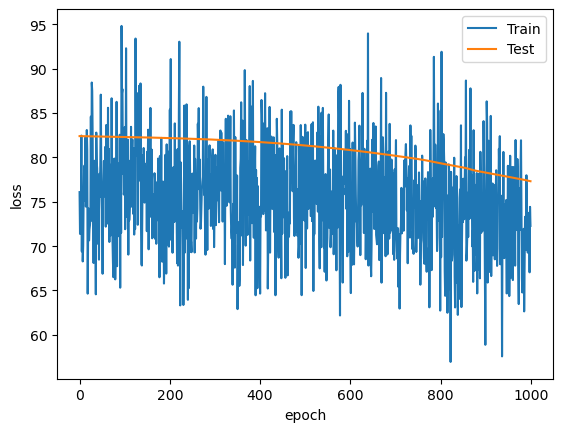

In [98]:
plt.plot(list(range(epochs)),lossList,label='Train')
plt.plot(list(range(epochs)),lossListTest,label='Test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [99]:
# 将"order_dt"列转换为日期类型
data['order_dt'] = pd.to_datetime(data['order_dt'])

# 创建条件来选择在指定日期范围内的数据
start_date = pd.to_datetime("2022-09-01")
end_date = pd.to_datetime("2022-09-30")
mask_train = (data['order_dt'] >= start_date) & (data['order_dt'] <= end_date)
mask_test = (~(data['order_dt'] >= start_date) & (data['order_dt'] <= end_date))

test1 = data[mask_test]


In [100]:
dataX1 = []  # 测试属性
dataY1 = []  # 测试标签
tempX = []  # 储存某个历史第0天数据
tempY = []  # 储存某个未来第1到168天数据

for index, rows in test1.iterrows():
    temp_data = [rows['pay_num'], rows['payment_orders'], rows['refund_orders'], rows['cancel_orders'],
                 rows['income'], rows['refund_income'], rows['actual_orders'], rows['续费率'], rows['实际收入'],
                 rows['保留率'], rows['ltv']]

    if len(tempX) == 0:
        tempX.append(temp_data)
    else:
        tempY.append(temp_data)

    if len(tempY) == 168:
        dataX1.append(tempX)
        dataY1.append(tempY)
        tempX = []
        tempY = []

In [101]:
X=torch.tensor(dataX1)
Y=model(X.view(len(dataX1),1,11).float()).reshape(len(dataX1),168*11)

In [102]:
a1 = []
for i in Y.tolist():
    a1.append(i[-1])
a2 = []
for i in dataY1:
    a2.append(i[-1][-1])

a2 = np.array(a2)
a1 = np.array(a1)

In [103]:
# 计算相对误差
relative_errors = np.abs((a2 - a1) / a2)

# 统计relative_errors中大于0.1的数量
count_greater_than_0_1 = (relative_errors > 0.1).sum()

# 统计relative_errors中小于等于0.1的数量
count_less_than_or_equal_to_0_1 = (relative_errors <= 0.1).sum()

print(f"大于0.1的数量：{count_greater_than_0_1}")
print(f"小于等于0.1的数量：{count_less_than_or_equal_to_0_1}")
print('合格率：', count_less_than_or_equal_to_0_1/(count_less_than_or_equal_to_0_1+count_greater_than_0_1))


大于0.1的数量：627
小于等于0.1的数量：2
合格率： 0.003179650238473768
